# LGBM Final

In [1]:
%load_ext autoreload

In [2]:
%run ../modules.ipynb

C:\Users\Matan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [3]:
init_data_paths("matan")

## Feature enrichment

In [4]:
print('loading data...')
train, test = load_data(DATA_PATH)

loading data...


In [5]:
train, test = basic_enrichment(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_image_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = load_text_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = add_aggregated_features(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = numeric_features_cleaning(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = complete_image_top_1(train, test, helper_data_path=HELPER_DATA_PATH)
train, test = complete_price(train, test, helper_data_path=HELPER_DATA_PATH)

Adding basic features...
Done adding basic features.
Adding image features...


C:\Users\Matan\Google Drive\ds-workshop\Avito\utils\feature_enrichment.py:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Matan\Google Drive\ds-workshop\Avito\utils\feature_enrichment.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done loading image features.
Loading text features...
loading tfidf features...
Done loading text features.
Loading aggregated features...
Done loading aggregated features.
Loading aggregated features...
Done loading aggregated features.
Cleaning and completing numeric features...


C:\Users\Matan\Google Drive\ds-workshop\Avito\utils\feature_enrichment.py:192: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Matan\Google Drive\ds-workshop\Avito\utils\feature_enrichment.py:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Done cleaning numeric features.
Completing image_top_1 features...
Done loading image_top_1 completions.
Completing price...
Done loading log_price_regression.


#### Encoding Labels

In [6]:
categorical_cols = ['user_type', 'user_id', \
                    'region', 'city', \
                    'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', \
                    'image_top_1_class', 'image_top_1_rounded_regression', \
                    'month', 'day', 'weekday', \
                    'has_price', 'has_description', 'has_params', 'has_image'
                   ]
import gc
gc.collect()
for col in categorical_cols:
    print ("Encoding "+ str(col) + "...")
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

Encoding user_type...
Encoding user_id...
Encoding region...
Encoding city...
Encoding parent_category_name...
Encoding category_name...
Encoding param_1...
Encoding param_2...
Encoding param_3...
Encoding image_top_1_class...
Encoding image_top_1_rounded_regression...
Encoding month...
Encoding day...
Encoding weekday...
Encoding has_price...
Encoding has_description...
Encoding has_params...
Encoding has_image...


#### Feature Selection

We first started with a small group of features and we gradually added new features which were later created(text,image,aggregated features).</br>
We then tried different groups of features and gradually eliminated redundant features - features with very low importance or that are highly correlated to other features or features that caused overfit and reduced our final validation score.</br>
This are the final set of features we decided to use in our model (which gave us the best validation and test result)</br>

In [7]:
list(train.columns)

['item_id',
 'user_id',
 'region',
 'city',
 'parent_category_name',
 'category_name',
 'param_1',
 'param_2',
 'param_3',
 'title',
 'description',
 'price',
 'item_seq_number',
 'activation_date',
 'user_type',
 'image',
 'image_top_1',
 'deal_probability',
 'has_description',
 'has_price',
 'has_params',
 'has_image',
 'month',
 'day',
 'weekday',
 'user_ads_count',
 'item_seq_number_count',
 'param_1_count',
 'param_2_count',
 'param_3_count',
 'title_description_params',
 'img_size',
 'img_sharpness',
 'img_luminance',
 'img_colorfulness',
 'img_confidence',
 'img_keypoints',
 'log_img_sharpness',
 'log_img_keypoints',
 'title_word_count',
 'description_non_regular_chars_ratio',
 'description_word_count',
 'merged_params_word_count',
 'description_sentence_count',
 'description_words/sentence_ratio',
 'title_capital_letters_ratio',
 'description_capital_letters_ratio',
 'title_non_regular_chars_ratio',
 'title_num_of_newrow_char',
 'description_num_of_newrow_char',
 'title_num_adj

In [8]:
categorical_cols = ['user_type', 'user_id', \
                    'region', 'city', \
                    'parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', \
                    'image_top_1_class', \
                    'has_price', 'has_description', 'has_params', 'has_image',
                   ]
numerical_cols = [   'log_price_regression','avg_days_up_user', 'avg_times_up_user', 'n_user_items', \
                     'item_seq_number',\
                     'img_size', 'img_luminance', 'img_colorfulness', 'img_confidence', 'log_img_sharpness', 'log_img_keypoints', \
                     'title_word_count', 'description_word_count', 'merged_params_word_count', \
                     'words_vs_unique_title', 'words_vs_unique_description', \
                     'num_desc_punct', 'num_unique_words_description', 'num_unique_words_title', \
                     'title_svd_1_ngram',
                     'title_svd_2_ngram',
                     'title_svd_3_ngram',
                     'title_svd_4_ngram',
                     'title_svd_5_ngram',
                     'title_svd_6_ngram',
                     'title_svd_7_ngram',
                     'title_svd_8_ngram',
                     'title_svd_9_ngram',
                     'title_svd_10_ngram',
                     'title_svd_11_ngram',
                     'title_svd_12_ngram',
                     'title_svd_13_ngram',
                     'title_svd_14_ngram',
                     'title_svd_15_ngram',
                     'title_svd_16_ngram',
                     'title_svd_17_ngram',
                     'title_svd_18_ngram',
                     'title_svd_19_ngram',
                     'title_svd_20_ngram',
                     'title_svd_21_ngram',
                     'title_svd_22_ngram',
                     'title_svd_23_ngram',
                     'title_svd_24_ngram',
                     'title_svd_25_ngram',
                     'title_svd_26_ngram',
                     'title_svd_27_ngram',
                     'title_svd_28_ngram',
                     'title_svd_29_ngram',
                     'title_svd_30_ngram',
                     'description_svd_1_ngram',
                     'description_svd_2_ngram',
                     'description_svd_3_ngram',
                     'description_svd_4_ngram',
                     'description_svd_5_ngram',
                     'description_svd_6_ngram',
                     'description_svd_7_ngram',
                     'description_svd_8_ngram',
                     'description_svd_9_ngram',
                     'description_svd_10_ngram',
                     'description_svd_11_ngram',
                     'description_svd_12_ngram',
                     'description_svd_13_ngram',
                     'description_svd_14_ngram',
                     'description_svd_15_ngram',
                     'description_svd_16_ngram',
                     'description_svd_17_ngram',
                     'description_svd_18_ngram',
                     'description_svd_19_ngram',
                     'description_svd_20_ngram',
                     'description_svd_21_ngram',
                     'description_svd_22_ngram',
                     'description_svd_23_ngram',
                     'description_svd_24_ngram',
                     'description_svd_25_ngram',
                     'description_svd_26_ngram',
                     'description_svd_27_ngram',
                     'description_svd_28_ngram',
                     'description_svd_29_ngram',
                     'description_svd_30_ngram', 
                 ]

feature_list = categorical_cols + numerical_cols + ['item_id']

def categorical_indices(df, categorical_cols):
    return [i for i, col in enumerate(df.columns) if col in categorical_cols]

#### Splitting data

In [9]:
X_df = train[feature_list].fillna(0)
y_df = train['deal_probability'].values

In [10]:
X_test_df = test[feature_list].fillna(0)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

In [11]:
X_train_item_id = X_train_df[['item_id']]
X_test_item_id = X_test_df[['item_id']]
X_val_item_id = X_val_df[['item_id']]
del X_train_df['item_id']
del X_test_df['item_id']
del X_val_df['item_id']

# LightGBM

* https://github.com/Microsoft/LightGBM/tree/master/examples/python-guide
* https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

We try both regression and poisson objectives in the ensemble model, so we train both.

In [12]:
objective = 'regression'

We started with the parameters we received from the hyperparmeter tuning and we gradually increased the number of leaves and decreased the learning rate (the number of leaves increases the model complexity and to avoid overfit we reduce the learning rate and use high number of training rounds) until our score stopped improving.

In [31]:
categorical_features_idx = categorical_indices(X_df, categorical_cols)
lgb_train = lgb.Dataset(X_train_df, label=y_train_df)
lgb_val = lgb.Dataset(X_val_df, y_val_df, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric': 'rmse',
    'max_depth': 15,
    'num_leaves': 512,
    'num_estimators':38,
    'feature_fraction': 0.6,
    'learning_rate': 0.005,
    'ransom_state':[501],
    'verbose': 1
}

def train_lgb(my_params, my_lgb_train, my_lgb_val):
    evals_result = {}
    clf = lgb.train(my_params, 
                    my_lgb_train, 
                    num_boost_round=16000,
                    valid_sets=[my_lgb_train, my_lgb_val],
                    early_stopping_rounds=200,
                    feature_name=feature_list[:-1],
                    categorical_feature=categorical_features_idx,
                    evals_result=evals_result,
                    verbose_eval=200)
    return clf, evals_result

clf, evals_result = train_lgb(params, lgb_train, lgb_val)

C:\Users\Matan\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning:

categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

C:\Users\Matan\Anaconda3\lib\site-packages\lightgbm\basic.py:681: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 0.228491	valid_1's rmse: 0.231106
[400]	training's rmse: 0.218879	valid_1's rmse: 0.224628
[600]	training's rmse: 0.213803	valid_1's rmse: 0.22245
[800]	training's rmse: 0.210243	valid_1's rmse: 0.221459
[1000]	training's rmse: 0.207317	valid_1's rmse: 0.220752
[1200]	training's rmse: 0.204895	valid_1's rmse: 0.22031
[1400]	training's rmse: 0.202797	valid_1's rmse: 0.220006
[1600]	training's rmse: 0.200906	valid_1's rmse: 0.219785
[1800]	training's rmse: 0.199142	valid_1's rmse: 0.2196
[2000]	training's rmse: 0.197481	valid_1's rmse: 0.219448
[2200]	training's rmse: 0.195883	valid_1's rmse: 0.219323
[2400]	training's rmse: 0.19441	valid_1's rmse: 0.219211
[2600]	training's rmse: 0.193014	valid_1's rmse: 0.219125
[2800]	training's rmse: 0.191688	valid_1's rmse: 0.219041
[3000]	training's rmse: 0.190444	valid_1's rmse: 0.218975
[3200]	training's rmse: 0.189297	valid_1's rmse: 0.21891
[3400]	training's r

In [14]:
def test_lgb(clf, X_test, y_test):
    y_pred = clf.predict(X_test, num_iteration= clf.best_iteration)
    y_pred = np.clip(y_pred, 0, 1)
    res = rmse(y_pred, y_test)
    print(res)
    return res
gc.collect()
results = {}
results['lgbm'] = { 'rmse': test_lgb(clf, X_val_df, y_val_df) }

0.218421243787329


### Analyzing results

Plot metrics during training...


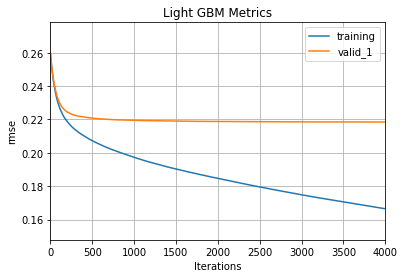

Plot feature importances...


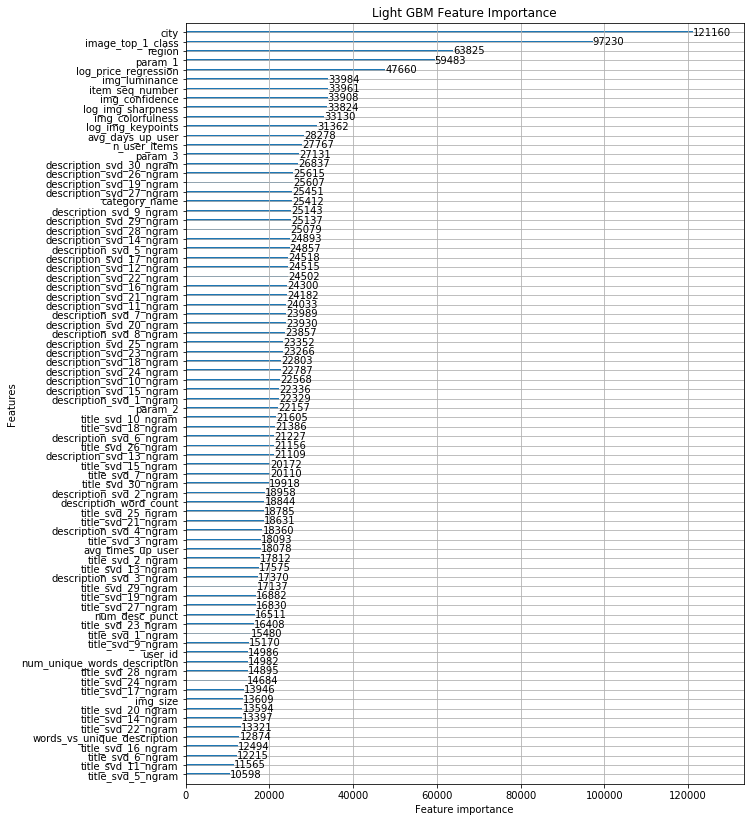

In [15]:
def analyze_lgbm_result():
    print('Plot metrics during training...')
    ax = lgb.plot_metric(evals_result, metric='rmse')
    plt.title("Light GBM Metrics")
    plt.show()

    print('Plot feature importances...')
    fig, ax = plt.subplots(figsize=(10, 14))
    lgb.plot_importance(clf, max_num_features=80, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()

#     print('Plot 84th tree...')  # one tree use categorical feature to split
#     ax = lgb.plot_tree(clf, tree_index=83, figsize=(20, 8), show_info=['split_gain'])
#     plt.show()

#     print('Plot 84th tree with graphviz...')
# #     graph = lgb.create_tree_digraph(clf, tree_index=83, name='Tree84')
# #     graph.render(view=True)
    
analyze_lgbm_result()

### Get Submission Result

In [16]:
y_pred = clf.predict(X_test_df)
y_pred = np.clip(y_pred, 0, 1)

In [17]:
res_df = pd.DataFrame(test['item_id'])
res_df['deal_probability'] = y_pred

In [18]:
res_df.to_csv('../submissions/submit_res_lgbm_%s_15.csv.gz' % objective, index=None, compression='gzip')

### Get predictions on all data to unify with an ensemble model

In [ ]:
y_train_pred = clf.predict(X_train_df)
res_train_df = pd.DataFrame(X_train_item_id['item_id'])
res_train_df['deal_probability'] = y_train_pred

In [ ]:
y_val_pred = clf.predict(X_val_df)
res_val_df = pd.DataFrame(X_val_item_id['item_id'])
res_val_df['deal_probability'] = y_val_pred

In [ ]:
y_test_pred = clf.predict(X_test_df)
res_test_df = pd.DataFrame(X_test_item_id['item_id'])
res_test_df['deal_probability'] = y_test_pred

In [ ]:
res = pd.concat([res_train_df, res_val_df, res_test_df], axis=0)

In [ ]:
res.to_csv('../all_data_lgbm_%s_results_0.2281.csv.gz' % objective, index=None, compression='gzip')

## Prediction Analysis

In [19]:
y_pred = clf.predict(X_val_df)

In [20]:
y_pred = np.clip(y_pred, 0, 1)
X_val_df['pred_dp'] = y_pred
X_val_df['real_dp'] = y_val_df
X_val_df['mistake'] = np.abs(y_val_df - y_pred)
bad_df = X_val_df.sort_values(by='mistake', ascending=False).iloc[:25000]
good_df = X_val_df.sort_values(by='mistake', ascending=True).iloc[:25000]

C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Matan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

We might wish to predict high price and low price seperately

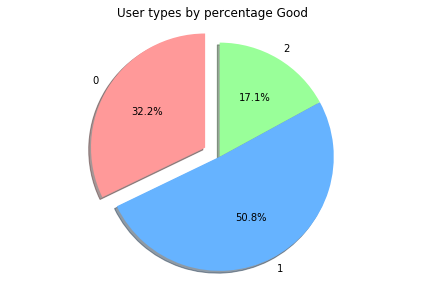

In [21]:
user_type_dist = good_df.groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('User types by percentage Good')
plt.show()

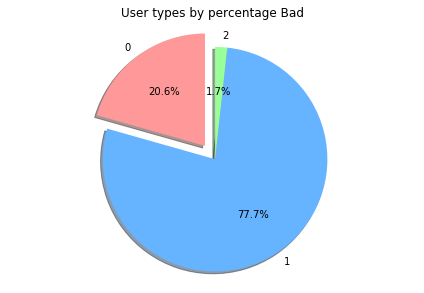

In [22]:
user_type_dist = bad_df.groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('User types by percentage Bad')
plt.show()

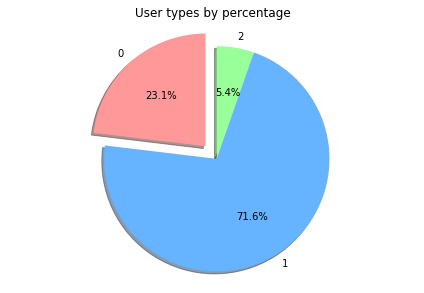

In [23]:
user_type_dist = X_df.groupby('user_type').size()
explode = (0.15, 0, 0)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = user_type_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(user_type_dist, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('User types by percentage')
plt.show()

We can see that we have higher success rate on the smaller classes of user types

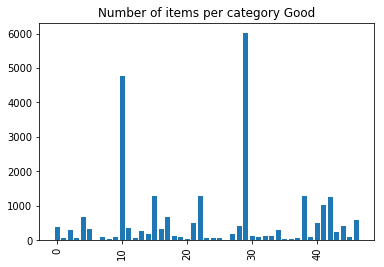

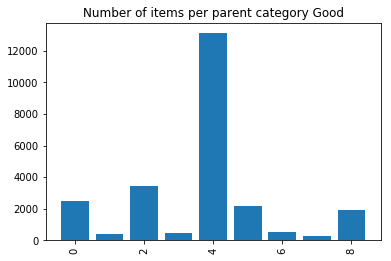

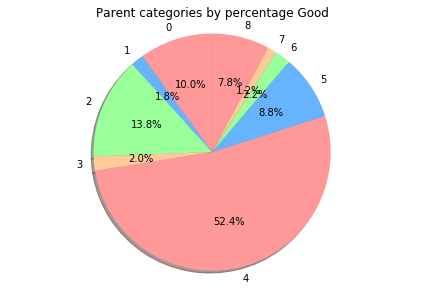

In [24]:
category_counts = good_df.groupby('category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per category Good')
plt.show()
category_counts = good_df.groupby('parent_category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per parent category Good')
plt.show()

parent_category_dist = good_df.groupby('parent_category_name').size()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = parent_category_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(parent_category_dist, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Parent categories by percentage Good')
plt.show()

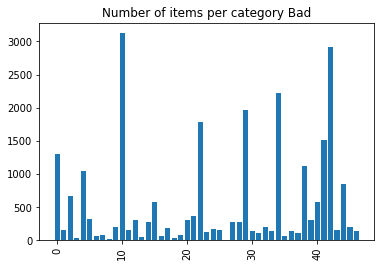

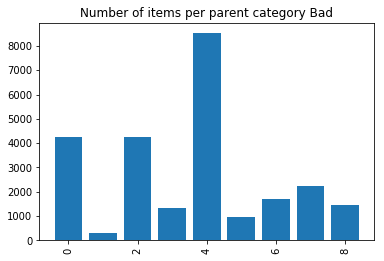

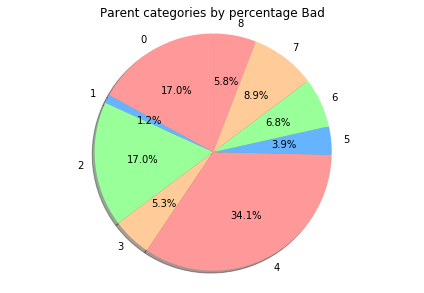

In [25]:
category_counts = bad_df.groupby('category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per category Bad')
plt.show()
category_counts = bad_df.groupby('parent_category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per parent category Bad')
plt.show()

parent_category_dist = bad_df.groupby('parent_category_name').size()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = parent_category_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(parent_category_dist, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Parent categories by percentage Bad')
plt.show()

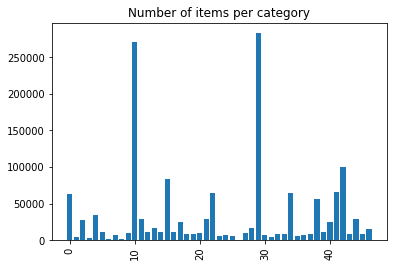

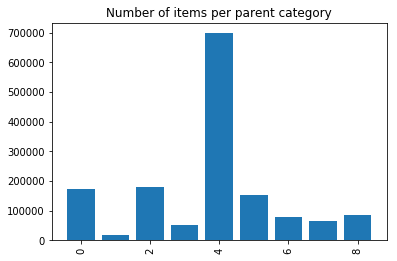

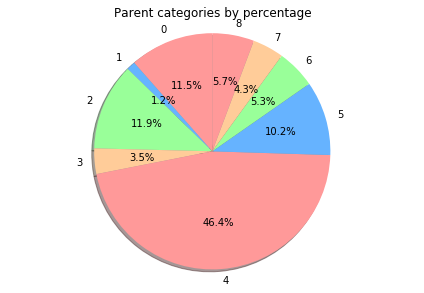

In [26]:
category_counts = X_df.groupby('category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per category')
plt.show()
category_counts = X_df.groupby('parent_category_name').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(category_counts.index, category_counts.values)
plt.title('Number of items per parent category')
plt.show()

parent_category_dist = X_df.groupby('parent_category_name').size()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels = parent_category_dist.index
fig1, ax1 = plt.subplots()
ax1.pie(parent_category_dist, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.tight_layout()
plt.title('Parent categories by percentage')
plt.show()

We don't predict well categories 0,2

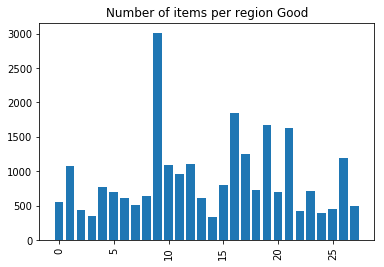

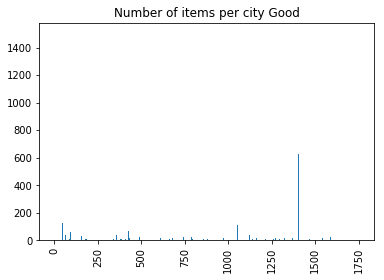

In [27]:
region_counts = good_df.groupby('region').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(region_counts.index, region_counts.values)
plt.title('Number of items per region Good')
plt.show()
city_counts = good_df.groupby('city').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(city_counts.index, city_counts.values)
plt.title('Number of items per city Good')
plt.show()

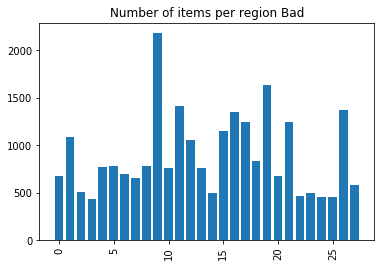

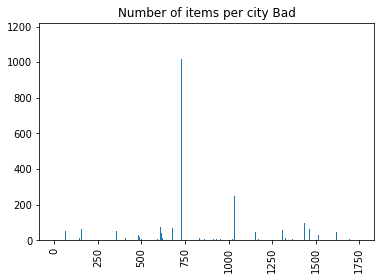

In [28]:
region_counts = bad_df.groupby('region').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(region_counts.index, region_counts.values)
plt.title('Number of items per region Bad')
plt.show()
city_counts = bad_df.groupby('city').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(city_counts.index, city_counts.values)
plt.title('Number of items per city Bad')
plt.show()

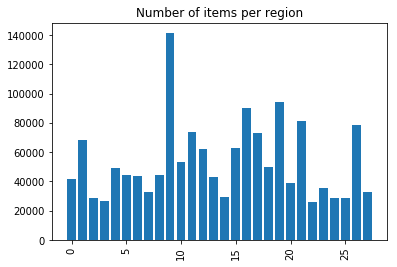

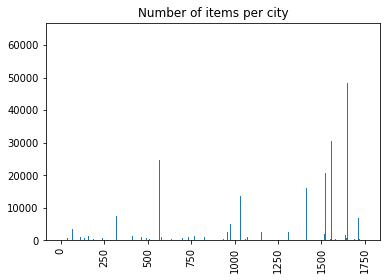

In [29]:
region_counts = X_df.groupby('region').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(region_counts.index, region_counts.values)
plt.title('Number of items per region')
plt.show()
city_counts = X_df.groupby('city').size().sort_values(ascending=False)
plt.xticks(rotation=90)
plt.bar(city_counts.index, city_counts.values)
plt.title('Number of items per city')
plt.show()